In [1]:
% matplotlib inline

import sys
import gc

import numpy as np

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from scipy.special import gammaln
from scipy.stats import chisquare, chi2

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import h5py
import pywt

import readligo as rl

In [2]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs)/dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [3]:
fs = 4096 # sampling rate

# get segment list. note that for now, I'm only using a small amount of
# data (1 file), but that this should be expandable to many more (currently
# I have about 50GB worth of data cached on my home desktop, which should
# be more than enough for this)
start = 931035615
stop = 932245215
fl = rl.FileList()
segList = rl.getsegs(start, stop, 'L1', flag='DATA', filelist=fl)
print segList

Using data directory . ...
WARNING!  No file found for GPS 931033088 and IFO L1
WARNING! No file found with GPS start time 931033088
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931037184 and IFO L1
WARNING! No file found with GPS start time 931037184
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931041280 and IFO L1
WARNING! No file found with GPS start time 931041280
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931045376 and IFO L1
WARNING! No file found with GPS start time 931045376
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931049472 and IFO L1
WARNING! No file found with GPS start time 931049472
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 931053568 and IFO L1
WARNING! No file found with GPS start time 931053568
Segment list may contain errors due to missing files.
WARNING!  No 

WARNING!  No file found for GPS 932216832 and IFO L1
WARNING! No file found with GPS start time 932216832
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 932220928 and IFO L1
WARNING! No file found with GPS start time 932220928
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 932225024 and IFO L1
WARNING! No file found with GPS start time 932225024
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 932229120 and IFO L1
WARNING! No file found with GPS start time 932229120
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 932233216 and IFO L1
WARNING! No file found with GPS start time 932233216
Segment list may contain errors due to missing files.
WARNING!  No file found for GPS 932237312 and IFO L1
WARNING! No file found with GPS start time 932237312
Segment list may contain errors due to missing files.
SegmentList( [(931999744, 932001215), (9

In [4]:
# loop over good segments
#fn_H1 = 'cache/H-H1_LOSC_4_V2-1126257414-4096.hdf5' #'cache/H-H1_LOSC_4_V2-1126259446-32.hdf5'
# 'H-H1_LOSC_4_V2-1126257414-4096.hdf5'
#strain, time, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
#begin = time[0]
#end = time[-1]
#ts = time[1]-time[0]

f = open('L1_times.csv', 'a')
#np.savetxt(f, ['# begin end del_t c_t c_s c_E signif seg_begin seg_eng cbc burst stoch'], fmt='%s')
f.close()


for (begin, end) in segList: # for q in [0]:
    gc.collect()
    strain, meta, dq = rl.getstrain(begin, end, 'L1', filelist=fl)
    ts = meta['dt']
    time = np.arange(begin, end, ts)
    
    # first whiten strain data
    NFFT = 1*fs    
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    
#     plt.figure()
#     plt.loglog(freqs, np.sqrt(Pxx),'r',label='H1 strain')
#     plt.axis([10, 2000, 1e-24, 1e-19])
#     plt.grid('on')
#     plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
#     plt.xlabel('Freq (Hz)')
#     plt.title('Advanced LIGO strain data near GW150914')
#     plt.savefig('GW150914_prewhite.png')
    
    strain_whiten = whiten(strain,psd,ts)
    
    Pxx_white, freqs_white = mlab.psd(strain_whiten, Fs=fs, NFFT=NFFT)
    psd_white = interp1d(freqs_white, Pxx_white)
    
#     plt.figure()
#     plt.loglog(freqs_white, np.sqrt(Pxx_white),'r',label='H1 strain')
#     plt.grid('on')
#     plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
#     plt.xlabel('Freq (Hz)')
#     plt.title('Whitened Advanced LIGO strain data near GW150914')
#     plt.savefig('GW150914_white.png')
    
    bb, ab = butter(4, [80.* 2. * ts, 300. * 2. * ts],btype='band') #butterworth bandpass 
    strain_whitenbp = filtfilt(bb, ab, strain_whiten)
    mid_slice = np.where((time - begin > 12.5) & (end - time > 12.5)) # slicing off the ends, which have been built up during whitening
    strain_whitenbp = strain_whitenbp[mid_slice]
    time = time[mid_slice]
    
    # plot of the whitened data and unwhitened data
    # not really relevant to final goals, but it shows the whitening is working!
#     figure1 = plt.figure(figsize=(10,8))
#     plt.subplot(2,1,1)
#     rel_time = np.arange(begin, end+ts, ts)
    
#     plt.plot(rel_time, strain)
#     plt.title('Raw Timeseries')
#     plt.xlabel('GPS Time($s$)')
    
#     plt.subplot(2,1,2)
#     plt.plot(rel_time, strain_whitenbp)
#     plt.title('Whitened Timeseries')
#     plt.xlabel('GPS Time($s$)')
    
#     plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    
    #------------------------------------------------------------
    
    # then wavelet decomposition.
    # returns [cA_n, cD_n, cD_n-1, ..., cD2, cD1]
    # where n is the decomposition level, and cA are the approximation coefficient arry
    # while cD are details coefficient arrays
    coeffs = pywt.wavedec(strain_whitenbp, 'haar') # using haar for now, as thats what LIGO apparently uses for this. will do more research later to verify reasoning
    D_coeffs = np.flipud(coeffs[1:]) # switching the order so that D_coeffs[i] corresponds to j=i+1 decomp level
    
    E_coeffs = np.array([])
    seg_times = np.array([])
    all_scales = np.array([])
    for scale, D_co in enumerate(D_coeffs):
        N = len(D_co)
        sigma = np.std(D_co)
        if (sigma == 0 or N == 0):
            continue
        sig_px = np.where(abs(D_co / sigma) > 5.)[0]
        
        scales = np.full(np.shape(sig_px),scale+1,dtype=np.int64)

        times = np.full(np.shape(sig_px),begin,dtype=np.float64)
        for i in range(len(sig_px)):
            times[i] += ((2.**(scale+1.)) / fs) * sig_px[i]
            
        seg_times = np.append(seg_times, times)
        all_scales = np.append(all_scales,scales).astype(np.int64)

        E_coeffs = np.append(E_coeffs,((D_co**2) /  (np.std(D_co)**2))[sig_px])
    
    if (len(E_coeffs) == 0):
        continue
        
    if (len(seg_times) > 0):
        data = np.vstack((seg_times, all_scales, E_coeffs)).T # multiplying by ts to rescale the scale axis
    #bw = 100. #set bandwidth to 2 "pixels"
    
    ms = MeanShift()#bandwidth=bw)
    try:
        ms.fit(data)
    except:
        continue
        
    labels = ms.labels_
    centers = ms.cluster_centers_
    
#     fig2 = plt.figure(figsize=(10,8))
#     plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
#     plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
#     plt.legend()
#     plt.title('')
#     plt.xlabel('GPS Time ($s$)')
#     plt.ylabel('$j$')
#     plt.savefig('GW150914_cluster.png')
    
    #------------------------------------------------------------
    f = open('L1_times.csv', 'a')
    event_data = np.array([])
    for label in np.unique(labels):
        pts = np.array(np.where(labels==label)[0])
        #if (len(pts) > len(E_coeffs)):
            
        try:
            clust = E_coeffs[pts]
            E_c = np.sum(clust)
            N_clust = len(clust)
        except:
            print(len(labels),len(E_coeffs))
            E_c = 0.
            N_clust = len(pts)
            for i in pts:
                if (i < len(E_coeffs)):
                    E_c += E_coeffs[i]
                    
        signif = -np.log(quad(chi2.pdf, E_c, np.inf, args=(N_clust,))[0])
        if (signif > 20.):
            cbc = False
            burst = False
            stoch = False
            b = min(seg_times[pts])
            e = max(seg_times[pts])
            del_t = e - b
            
            inj_slice = rl.dq_channel_to_seglist(dq['HW_CBC'])
            for sl in inj_slice:
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                if ((centers[label][0] >= inj_start ) and (centers[label][0] <= inj_end)):
                    cbc = True
                    break
            
            inj_slice = rl.dq_channel_to_seglist(dq['HW_BURST'])
            for sl in inj_slice:
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                if ((centers[label][0] >= inj_start ) and (centers[label][0] <= inj_end)):
                    burst = True
                    break
            
            inj_slice = rl.dq_channel_to_seglist(dq['HW_STOCH'])
            for sl in inj_slice:
                inj_time = time[sl]
                inj_start, inj_end = inj_time[0],inj_time[-1]
                if ((centers[label][0] >= inj_start ) and (centers[label][0] <= inj_end)):
                    stoch = True
                    break
    
            
            
            if (len(event_data) == 0):
                event_data = np.array([b,e,del_t,centers[label][0],centers[label][1],centers[label][2],signif,begin,end,cbc,burst,stoch])
            else:
                time_coords = np.array([b,e,del_t,centers[label][0],centers[label][1],centers[label][2],signif,begin,end,cbc,burst,stoch])
                event_data = np.vstack((event_data,time_coords))
    
    np.savetxt(f, event_data, delimiter=' ')
    f.close()

print("done")

Loading ./cache/L1/L-L1_LOSC_4_V1-931999744-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932007936-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932012032-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932016128-4096.hdf5


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in log


Loading ./cache/L1/L-L1_LOSC_4_V1-932016128-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932020224-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932024320-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932024320-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932028416-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932032512-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932036608-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932036608-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932040704-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932044800-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932048896-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932052992-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932057088-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932061184-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932065280-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932069376-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932073472-4096.hdf5
Loading ./cache/L1/L-L1_LOSC_4_V1-932077568-4096.hdf5
Loading ./cache/L1/L-L1_LOSC

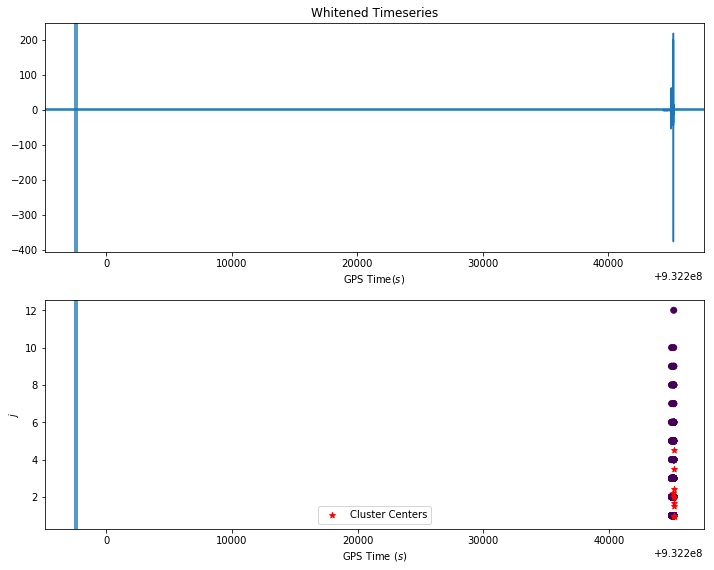

In [5]:
figure1 = plt.figure(figsize=(10,8))
plt.rcParams['agg.path.chunksize'] = 10000

# rel_time = np.arange(begin, end, ts)

# where_slice = np.where((rel_time - begin > 10.) & (end - rel_time > 10.))
# where_sliceb = np.where((rel_time - begin > 0.0175))
# where_slicee = np.where((end - rel_time > 0.0175))
# print(strain_whitenbp[where_slice])
#print(D_coeffs[0][5000:5050])
#print(np.std(D_coeffs[0]))

plt.subplot(2,1,1)
plt.plot(time, strain_whitenbp)
plt.title('Whitened Timeseries')
plt.xlabel('GPS Time($s$)')
plt.axvline(x=inj_start)
plt.axvline(x=inj_end)
plt.axhline(y=np.std(strain_whitenbp))
plt.axhline(y=np.std(5 * strain_whitenbp))

plt.subplot(2,1,2)
plt.scatter(seg_times,all_scales,c=labels,cmap=plt.cm.viridis)
plt.scatter(centers[:,0],centers[:,1],marker='*',c='r',label='Cluster Centers')
plt.legend()
plt.title('')
plt.xlabel('GPS Time ($s$)')
plt.ylabel('$j$')
plt.axvline(x=inj_start)
plt.axvline(x=inj_end)

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.show()

In [6]:
print(centers, label)
print(inj_start,inj_end)

(array([[  9.32245138e+08,   2.23711340e+00,   2.33535434e+02],
       [  9.32245160e+08,   2.42857143e+00,   2.73675928e+04],
       [  9.32245160e+08,   1.66666667e+00,   2.03448691e+04],
       [  9.32245160e+08,   2.00000000e+00,   1.97833416e+05],
       [  9.32245160e+08,   1.00000000e+00,   5.65609257e+04],
       [  9.32245160e+08,   3.50000000e+00,   1.38634382e+05],
       [  9.32245160e+08,   4.50000000e+00,   4.23406220e+04],
       [  9.32245160e+08,   1.50000000e+00,   2.42292564e+05],
       [  9.32245160e+08,   1.00000000e+00,   1.14068083e+05],
       [  9.32245160e+08,   2.00000000e+00,   1.32180567e+05],
       [  9.32245160e+08,   1.00000000e+00,   2.59418980e+05],
       [  9.32245160e+08,   1.00000000e+00,   3.68135749e+04],
       [  9.32245160e+08,   1.00000000e+00,   2.07674054e+05],
       [  9.32245160e+08,   1.00000000e+00,   1.04884315e+05]]), 13)
(932197502.50024414, 932197652.5)


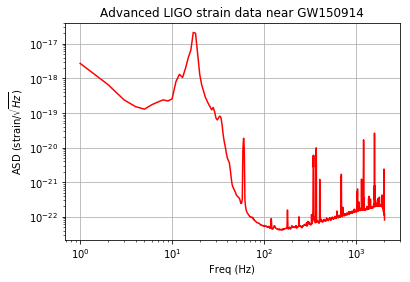

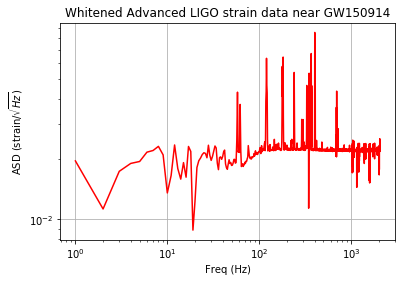

In [7]:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx),'r',label='H1 strain')
#plt.axis([10, 2000, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_prewhite.png')

plt.figure()
plt.loglog(freqs_white, np.sqrt(Pxx_white),'r',label='H1 strain')
plt.grid('on')
plt.ylabel('ASD (strain/$\sqrt{Hz}$)')
plt.xlabel('Freq (Hz)')
plt.title('Whitened Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_white.png')

In [8]:
print(np.version.version)

1.11.2
